In [1]:
#this is the main file


#importing required libraries

from classes.constantsmd import *
from classes.gridmd import *
from classes.functionsmd import *
from numpy import sin, cos, deg2rad, matrix, size, invert, multiply, array, sqrt, ones, empty, sum, average, abs
from matplotlib.pyplot import plot

#import matplotlib.pyplot as plt
#from sympy import init_printing
#from mpl_toolkits.mplot3d import Axes3D
#import csv
#import pandas as pd
print("-----------start-----------")

called constantmd
called gridmd
called functionsmd
-----------start-----------


In [3]:
N = N_xyz(100,6,6)
coor_0 = initialPos(N,ial)
xyz_grid = xyz_grid(coor_0[0], coor_0[1], coor_0[2])

In [4]:
def r(x1, y1, z1, x2, y2, z2):
    return sqrt( (xyz_grid[x2][y2][z2][0]-xyz_grid[x1][y1][z1][0])**2 + 
                (xyz_grid[x2][y2][z2][1]-xyz_grid[x1][y1][z1][1])**2 +
                (xyz_grid[x2][y2][z2][2]-xyz_grid[x1][y1][z1][2])**2 )
def forceXLJ3(x, y, z):
    rg = np.array([-1,0,1])
    pot = 0
    fx = 0
    for ri in rg:
        for rj in rg:
            for rk in rg:
                if (ri==0 and rj==0 and rk==0):
                    pass
                else:
                    i=ri;j=rj;k=rk;check=1;checki=1;checkj=1;checkk=1;
                    
                    if(x+ri<0 or x+ri>=N[0]):
                        i=0;check=0;checki=0;
                    if(y+rj<0 or y+rj>=N[1]):
                        j=0;check=0;checkj=0;
                    if(z+rk<0 or z+rk>=N[2]):
                        k=0;check=0;checkk=0;
                    if(check==1):
                        #print(ri,rj,rk)
                        #print(r(x,y,z,x+i,y+j,z+k))
                        pot += LJ(r(x,y,z,x+i,y+j,z+k))
                        fx += forceLJ(r(x,y,z,x+i,y+j,z+k),xyz_grid[i][j][k][0],xyz_grid[i+1][j][k][0])
                        #print("LJ: ",LJ(r(x,y,z,x+i,y+j,z+k)))
    #print("potential: ", pot)
    #print("force along x: ", fx)
    return fx


In [5]:
x1, x2, x3 = xyz_grid[0][0][0][0], xyz_grid[1][0][0][0], xyz_grid[2][0][0][0]

In [6]:
avagadro = 6.023e-23
ial = 4.04e-10 #interatomic length
epsilon = 0.5* 1.6e-19 #1.5 #dummy value
sigma = 2.85e-10 #dummy value
vel = 1000 #velocity per step
acc = 0 #acceleration
ts = 5e-9 #timestep ex: 0.005 nano seconds as 0.005e-9
N_steps = 10

inf 	 nan
nan 	 nan
nan 	 nan
nan 	 nan
nan 	 nan
nan 	 nan
nan 	 nan
nan 	 nan
nan 	 nan


C:\Users\Krish\Documents\GitHub\elastic_modulus_python_md\classes\functionsmd.py:14: RuntimeWarning: overflow encountered in double_scalars
  Fxij = 24*epsilon*f**6*(2*f**6 - 1)/r*(x1-x2)/r
C:\Users\Krish\Documents\GitHub\elastic_modulus_python_md\classes\functionsmd.py:14: RuntimeWarning: invalid value encountered in double_scalars
  Fxij = 24*epsilon*f**6*(2*f**6 - 1)/r*(x1-x2)/r
C:\Users\Krish\Documents\GitHub\elastic_modulus_python_md\classes\functionsmd.py:23: RuntimeWarning: invalid value encountered in double_scalars
  pos_t_dt = 2*pos - pos*(t-ts) + acc * ts**2; pos = pos_t_dt


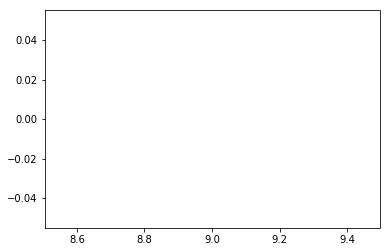

In [7]:
vpos = empty(N_steps)
old = x1
for i in range(N_steps-1):
    #print(verlet_pos(old,i*ts,ts,acc),"\n")
    acc = forceLJ(vpos[i+1]-vpos[i],vpos[i],vpos[i+1])/avagadro
    vpos[i]=verlet_pos(old,i*ts,ts,acc)
    old = vpos[i]
    
    print(vpos[i],'\t',forceLJ(vpos[i+1]-vpos[i],vpos[i],vpos[i+1])/avagadro)
plot(range(N_steps),vpos)

In [8]:
print("------------end------------")

------------end------------
